### Load libraries

In [40]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
import time
import pickle
from matplotlib import pyplot as plt

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve, auc

path_main_folder = '/home/antorosi/Documents/Prediction'
sys.path.append(path_main_folder)

from conso.load_shape_data import load_data_conso, get_uniformed_data_conso, change_granularity, get_x_y_prediction_conso, get_train_test_sets, normalized_dataset, select_variables
from aed.detection import get_residuals, get_atypical_score, get_atypical_ds, prediction_conso_plot
from aed.atypical_event import AtypicalEvent, AtypicalEventsList, get_atypical_events_list, apply_ael_to_df, get_confusion_matrix
from aed.verification import *
from aed.multi_period import get_prediction_results, get_aed_results, get_complete_df

### Get original data 

In [91]:
# Load
path_data = os.path.join(path_main_folder, 'data')
dict_data_conso = load_data_conso(path_data)

# Uniformization
data_conso_df, dict_colnames_conso = get_uniformed_data_conso(dict_data_conso)

# Granularity from 15 min to 1H
data_conso_df = change_granularity(data_conso_df, granularity="1H")

### Multi period prediction and aed results

In [92]:
# model paths
path_models_folder = os.path.join(path_main_folder, 'out', 'cv_model_lr_0')
name_dict_dataset = 'dict_datasets.pickle'
name_model = 'linear regression'
#name_model = 'random forest'

In [93]:
# get prediction results
prediction_results = get_prediction_results(path_models_folder, name_dict_dataset, mode=2, type_model='sklearn')

In [94]:
prediction_results.keys()

dict_keys(['period_4', 'period_5', 'period_3', 'period_1', 'period_2'])

In [95]:
# get atypical events info
threshold = 0.90
aed_results, ael_full_model = get_aed_results(prediction_results, threshold)

### Comparing results with reference and getting scores 

In [96]:
# Loading list
path_data = os.path.join("/local/home/antorosi/Documents/Prediction/data")
with open(os.path.join(path_data, 'ae_reference_list_wwe_2013-2017' + '.pickle'), 'rb') as f:
    ael_reference= pickle.load(f)

In [97]:
ael_results = ael_reference.strict_comparison(ael_full_model)

In [98]:
nb_events = 1825

In [99]:
dict_confusion_matrix = get_confusion_matrix(ael_results, nb_events)

In [100]:
dict_confusion_matrix

{'a': 43, 'b': 20, 'c': 3, 'd': 1759}

In [101]:
get_all_scores(dict_confusion_matrix)

{'csi': 0.6515151515151515,
 'f': 0.011242270938729624,
 'far': 0.31746031746031744,
 'gss': 0.642923982577923,
 'h': 0.9347826086956522,
 'hss': 0.7826582232600999,
 'pc': 0.9873972602739726,
 'pss': 0.9235403377569226}

### Plotting results 

In [102]:
# getting complete dataframe
atypical_full_df, prediction_full_df = get_complete_df(prediction_results, aed_results)

In [103]:
# applying verification to df
atypical_full_df = apply_ael_to_df(atypical_full_df, ael_results)

In [104]:
# plotting
path_plot = '/home/antorosi/Documents/Prediction/out/figures'
name_plot = 'full_period_lr0_mode2_wwe_t0.90.html'

prediction_conso_plot(data_conso_df, atypical_full_df, prediction_full_df, dict_colnames_conso, path_plot, name_plot)

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]
[ (4,1) x1,y4 ]



'file:///home/antorosi/Documents/Prediction/out/figures/full_period_lr0_mode2_wwe_t0.90.html'

### Knee technique 

In [67]:
a_score_df  = atypical_full_df[['a_score','ds']].copy()

In [68]:
a_score_df = a_score_df.sort_values('a_score')

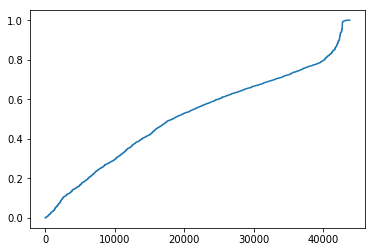

In [69]:
plt.plot(np.array(a_score_df.a_score))

### Wrong results analysis 

In [19]:
results_df = ael_results.get_events_list().copy()

In [20]:
results_df['is_week_day']= np.array(results_df.date_start.dt.dayofweek <5).astype(int)

In [21]:
# week end

mask = (results_df.is_week_day==0) & (results_df.is_atypical==1)
nb_tp_we = len(results_df[mask])

mask = (results_df.is_week_day==0) & (results_df.is_atypical==-1)
nb_fn_we = len(results_df[mask])

nb_hd_we = nb_tp_we+nb_fn_we

print('holiday day on week end: ' + str(nb_hd_we))
print('holiday day on week end detected: ' + str(nb_tp_we))


holiday day on week end: 0
holiday day on week end detected: 0


##### Get dependance with threshold

In [70]:
list_threshold = [0,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.70, 0.75,0.8,0.85,0.88,0.9,0.92,0.94,0.95,0.96,0.97,0.98,0.99,1]  

In [71]:
# initialization
threshold = list_threshold[0]
aed_results, ael_full_model = get_aed_results(prediction_results, threshold)
ael_results = ael_reference.strict_comparison(ael_full_model)
dict_confusion_matrix = get_confusion_matrix(ael_results, nb_events)
dict_result = get_all_scores(dict_confusion_matrix)

results_df = ael_results.get_events_list().copy()
results_df['is_week_day']= np.array(results_df.date_start.dt.dayofweek <5).astype(int)
mask = (results_df.is_week_day==0) & (results_df.is_atypical==1)
nb_tp_we = len(results_df[mask])

dict_results = {}
dict_results['nb_tp_we'] = [nb_tp_we]
for key, value in dict_result.items():
    dict_results[key] = [value]

# loop
for threshold in list_threshold[1:]:
    aed_results, ael_full_model = get_aed_results(prediction_results, threshold)
    ael_results = ael_reference.strict_comparison(ael_full_model)
    dict_confusion_matrix = get_confusion_matrix(ael_results, nb_events)
    dict_result = get_all_scores(dict_confusion_matrix)

    if threshold == 1:
        dict_result['far']=0
    
    results_df = ael_results.get_events_list().copy()
    results_df['is_week_day']= np.array(results_df.date_start.dt.dayofweek <5).astype(int)
    mask = (results_df.is_week_day==0) & (results_df.is_atypical==1)
    nb_tp_we = len(results_df[mask])

    dict_results['nb_tp_we'].append(nb_tp_we)
    for key, value in dict_result.items():
        dict_results[key].append(value)

dict_results['threshold'] = list_threshold

In [72]:
dict_results['nb_tp_we']

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

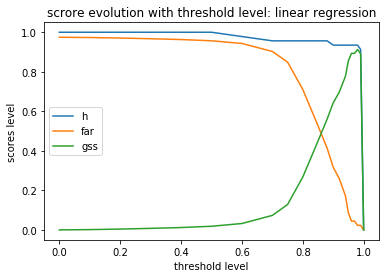

In [73]:
fig = plt.figure()

#plt.plot(dict_results['threshold'],[el/9 for el in dict_results['nb_tp_we']], label=('nb_tp_we'))
plt.plot(dict_results['threshold'],dict_results['h'], label='h')
plt.plot(dict_results['threshold'],dict_results['far'], label='far')
plt.plot(dict_results['threshold'],dict_results['gss'], label='gss')

plt.legend()
plt.title('scrore evolution with threshold level: ' + name_model)
plt.xlabel('threshold level')
plt.ylabel('scores level')
plt.show()

In [74]:
path_plot = '/home/antorosi/Documents/Prediction/out/figures'
name_plot = 'Score_evolution_wwe_t_' + name_model + '.png'

fig.savefig(os.path.join(path_plot, name_plot))

In [75]:
 roc_auc = auc(dict_results['f'], dict_results['h'])

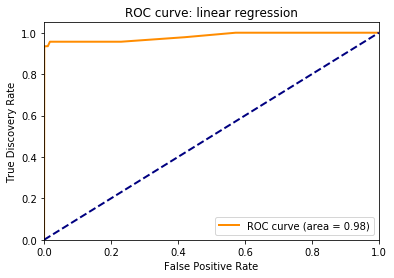

In [76]:
fig = plt.figure()
lw = 2
plt.plot(dict_results['f'], dict_results['h'], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Discovery Rate')
plt.title('ROC curve: ' + name_model)
plt.legend(loc="lower right")
plt.show()

In [77]:
path_plot = '/home/antorosi/Documents/Prediction/out/figures'
name_plot = 'ROC_wwe_' + name_model + '.png'

fig.savefig(os.path.join(path_plot, name_plot))

In [78]:
list_threshold = [0.90,0.91,0.92,0.93,0.94, 0.95,0.96,0.97,0.975,0.98,0.982,0.984,0.986,0.988,0.99, 0.992,0.994,0.996,0.998,0.999,1]  
dict_results = get_all_scores_multi_t(list_threshold, prediction_results, ael_reference, nb_events)

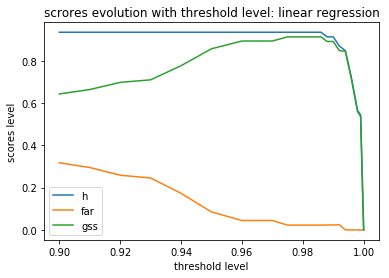

In [79]:
fig = plt.figure()

#plt.plot(dict_results['threshold'],[el/9 for el in dict_results['nb_tp_we']], label=('nb_tp_we'))
plt.plot(dict_results['threshold'],dict_results['h'], label='h')
plt.plot(dict_results['threshold'],dict_results['far'], label='far')
plt.plot(dict_results['threshold'],dict_results['gss'], label='gss')

plt.legend()
plt.title('scrores evolution with threshold level: ' + name_model)
plt.xlabel('threshold level')
plt.ylabel('scores level')
plt.show()

In [80]:
path_plot = '/home/antorosi/Documents/Prediction/out/figures'
name_plot = 'Score_evolution_zoom_wwe_t_' + name_model +'.png'

fig.savefig(fname=os.path.join(path_plot, name_plot))

In [81]:
max(dict_results['gss'])

0.9128368616494131